In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
import os

relative_data_path = '../../data/kaggle-archive/PJME_hourly.csv'
current_dir = os.getcwd()
# join the current directory and data path
data_path = os.path.join(current_dir, relative_data_path)

pjme = pd.read_csv(data_path,
                   index_col=[0],
                   parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


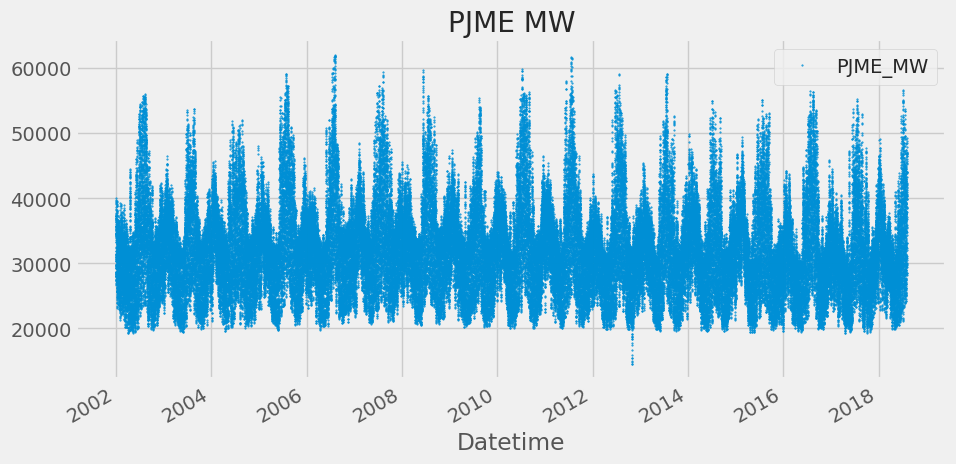

In [3]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [4]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)


def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                          )

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'season']]
    if label:
        y = df[label]
        return X, y
    return X


X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

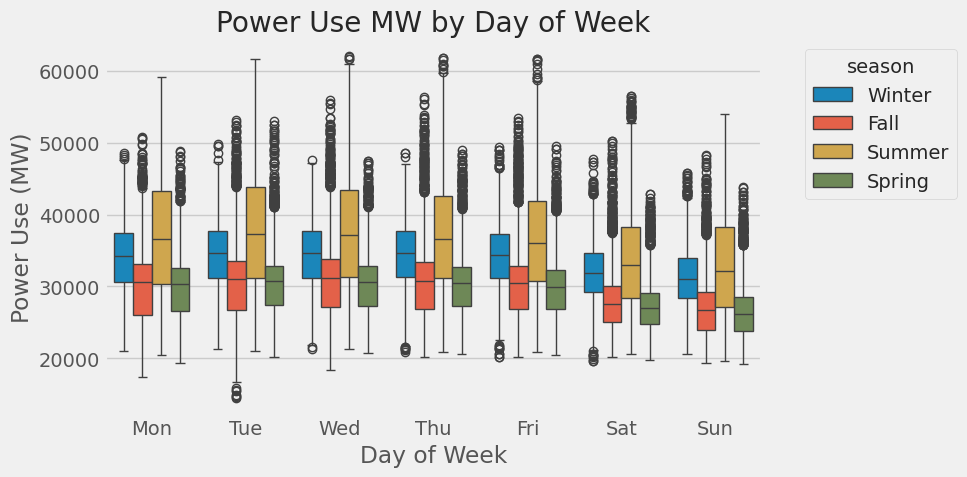

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming features_and_target has a datetime column or index
# If datetime is a column, convert it to index:
if 'Datetime' in features_and_target.columns:
    features_and_target['Datetime'] = pd.to_datetime(features_and_target['Datetime'])
    features_and_target = features_and_target.set_index('Datetime')
else:
    # If already an index, ensure it's datetime type
    features_and_target.index = pd.to_datetime(features_and_target.index)

# Create time-based features
features_and_target['weekday'] = features_and_target.index.weekday
features_and_target['month'] = features_and_target.index.month


# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


features_and_target['season'] = features_and_target['month'].apply(get_season)

# Now create the boxplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Power Use (MW)')

# Optional: Set better x-axis labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(day_labels)

plt.legend(title='season', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Train / Test Split

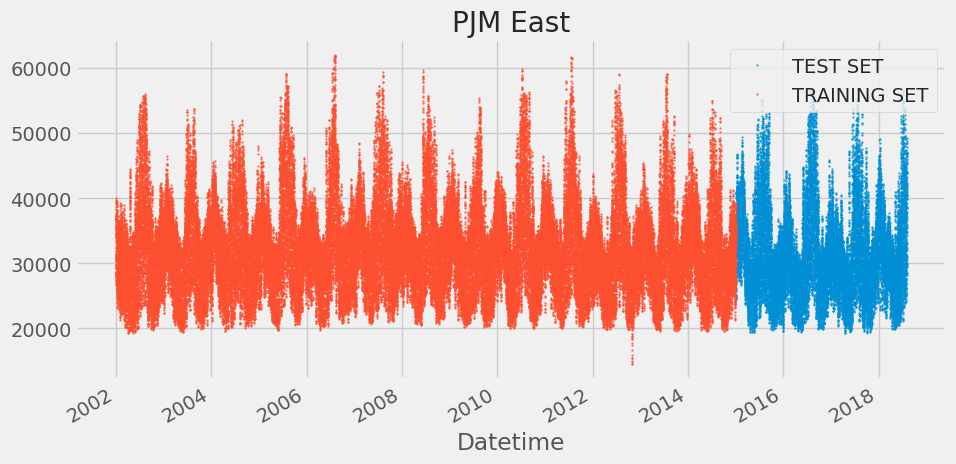

In [6]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()
pjme_test = pjme_test
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

### Simple Prophet Model

In [7]:
# Format data for a prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

#### Train the model

In [8]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

03:13:00 - cmdstanpy - INFO - Chain [1] start processing
03:13:31 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.96 s, sys: 139 ms, total: 4.1 s
Wall time: 35.4 s


In [9]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [10]:
pjme_test_fcst = pjme_test_fcst.sort_index()

In [11]:
# result
pjme_test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.828952,23686.539384,32694.434175,31210.828952,31210.828952,-2893.744621,-2893.744621,-2893.744621,-4430.274886,...,1281.327002,1281.327002,1281.327002,255.203263,255.203263,255.203263,0.0,0.0,0.0,28317.084331
1,2015-01-01 02:00:00,31210.792144,22334.078337,31374.893605,31210.792144,31210.792144,-4398.241671,-4398.241671,-4398.241671,-5927.275057,...,1272.572288,1272.572288,1272.572288,256.461099,256.461099,256.461099,0.0,0.0,0.0,26812.550473
2,2015-01-01 03:00:00,31210.755336,21737.662933,30621.451283,31210.755336,31210.755336,-5269.976752,-5269.976752,-5269.976752,-6790.348728,...,1262.611487,1262.611487,1262.611487,257.760489,257.760489,257.760489,0.0,0.0,0.0,25940.778583
3,2015-01-01 04:00:00,31210.718527,21362.080126,30391.518182,31210.718527,31210.718527,-5411.458676,-5411.458676,-5411.458676,-6922.128354,...,1251.568218,1251.568218,1251.568218,259.101460,259.101460,259.101460,0.0,0.0,0.0,25799.259851
4,2015-01-01 05:00:00,31210.681719,22247.631358,31032.520544,31210.681719,31210.681719,-4737.020385,-4737.020385,-4737.020385,-6237.082737,...,1239.578314,1239.578314,1239.578314,260.484037,260.484037,260.484037,0.0,0.0,0.0,26473.661334


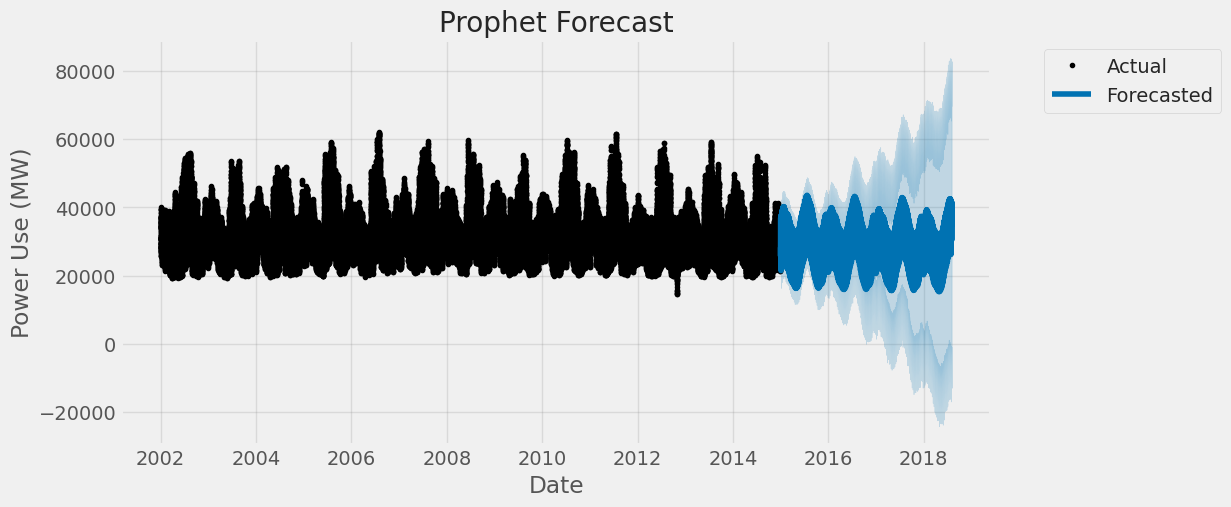

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Power Use (MW)')
# Add label for  color
plt.legend(labels=['Actual', 'Forecasted'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

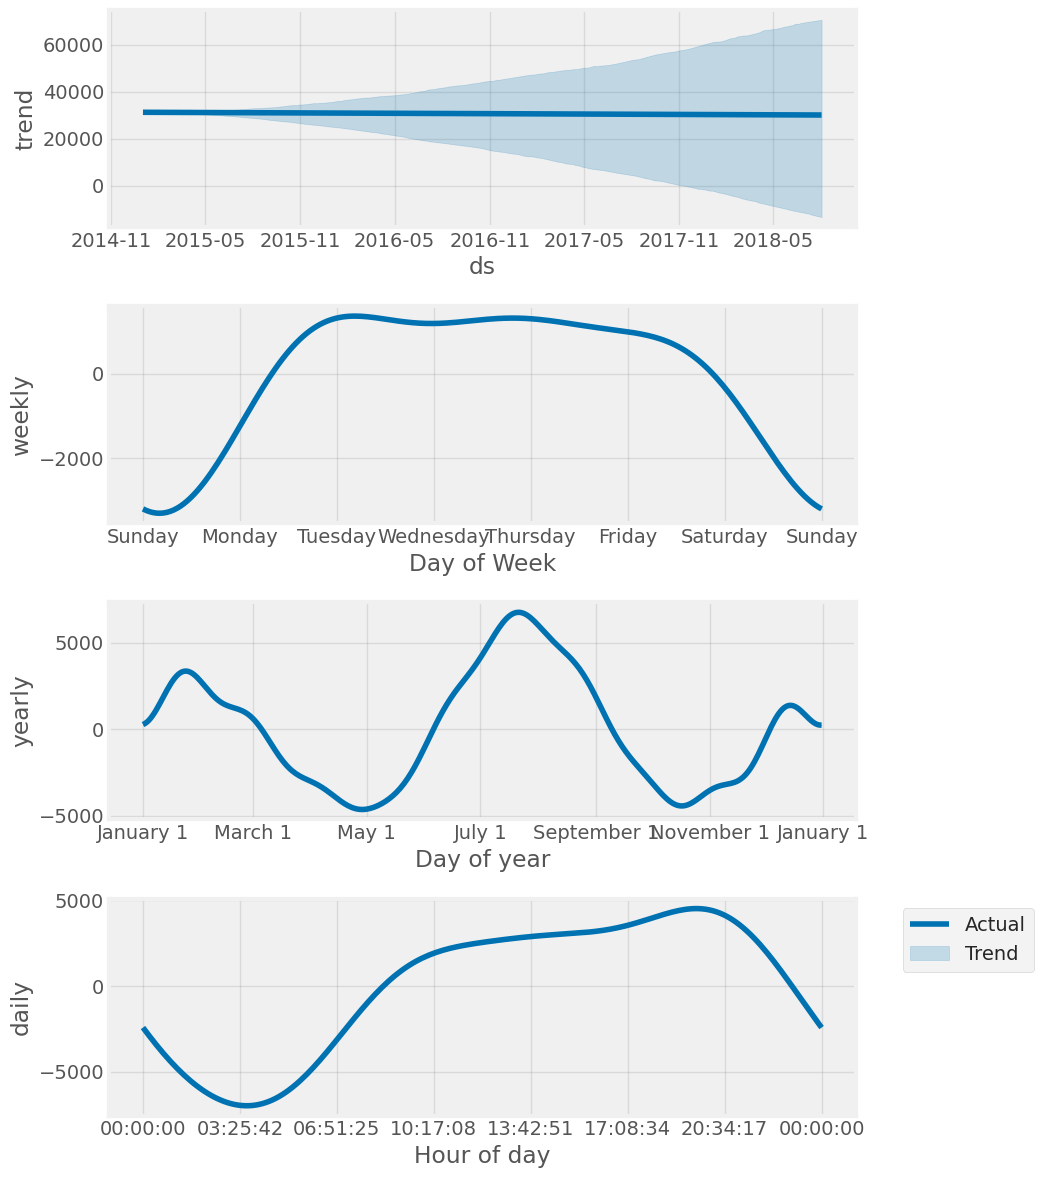

In [13]:
fig = model.plot_components(pjme_test_fcst)
# Add label for  color
plt.legend(labels=['Actual', 'Trend', 'Seasonality', 'Holiday Effects'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.show()

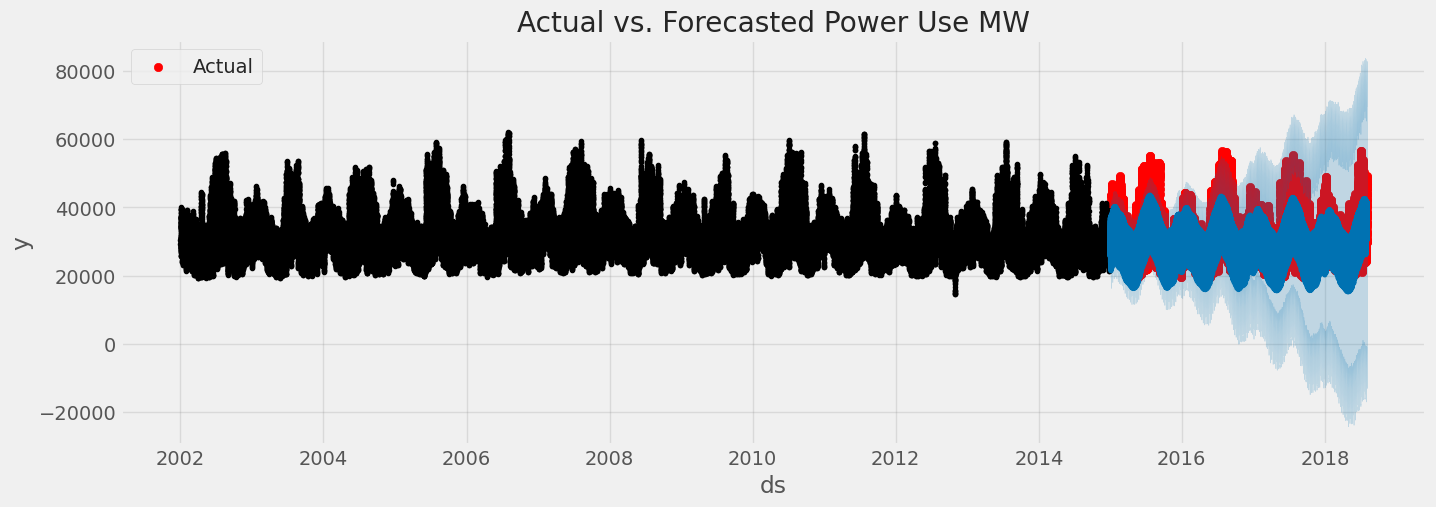

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
# Add a label for each color
ax.set_title('Actual vs. Forecasted Power Use MW')
ax.set_ylabel('Power Use (MW)')
ax.set_xlabel('Date')
plt.legend(['Actual', 'Forecasted'])

fig = model.plot(pjme_test_fcst, ax=ax)

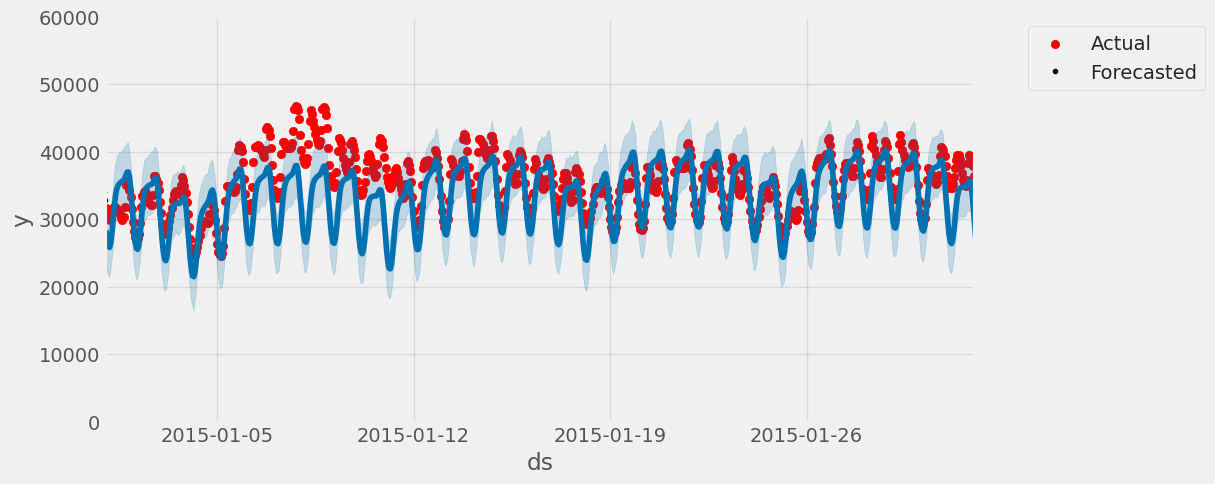

<Figure size 640x480 with 0 Axes>

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
import pandas as pd

ax.set_xbound(lower=pd.to_datetime('2015-01-01'),
              upper=pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 60000)
# add legend for color
plt.legend(labels=['Actual', 'Forecasted'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plot = plt.suptitle('January 2015 Forecast vs Actuals')

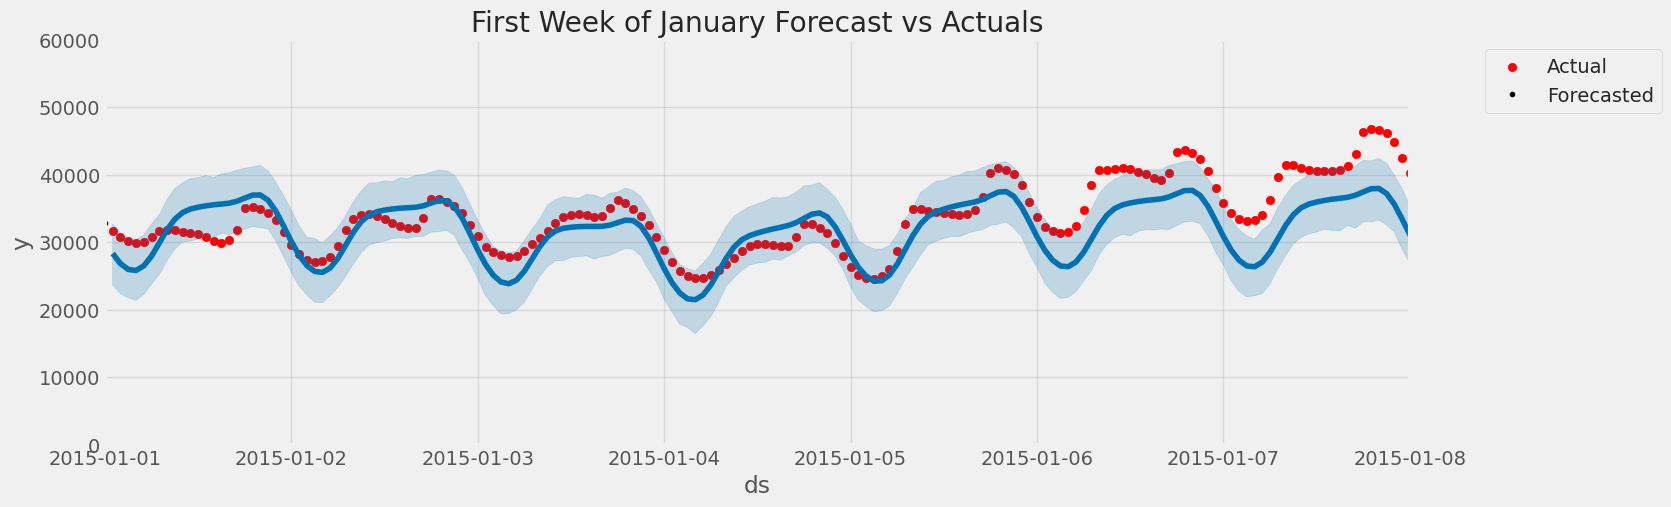

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), upper=pd.to_datetime('2015-01-08'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
# add legend for color
plt.legend(labels=['Actual', 'Forecasted'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plot = plt.suptitle('First Week of January Forecast vs Actuals')
plt.show()


### Evaluate the model with Error Metrics

In [17]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

np.float64(6616.929727126127)

In [18]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.902492927457

In [19]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(16.512083240542825)

### Adding Holidays

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [21]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

03:13:44 - cmdstanpy - INFO - Chain [1] start processing
03:14:33 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4.98 s, sys: 196 ms, total: 5.18 s
Wall time: 54.8 s


In [22]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)


In [23]:
pjme_test_fcst_with_hols = pjme_test_fcst_with_hols.sort_index()

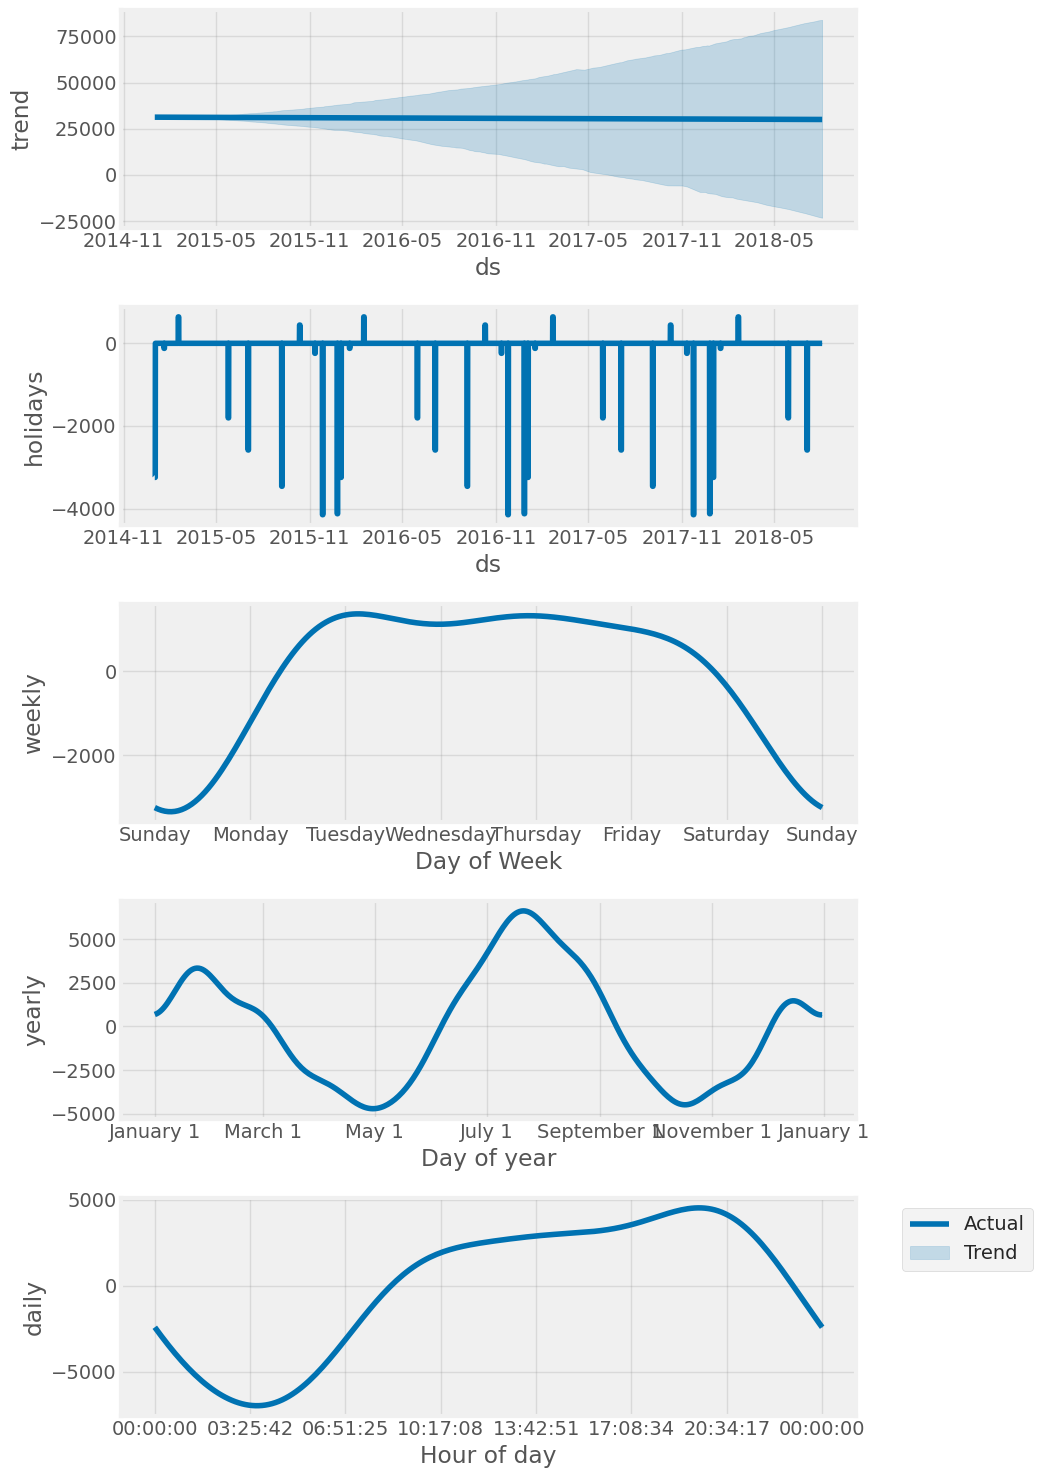

In [24]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
# add legend for color
plt.legend(labels=['Actual', 'Trend', 'Seasonality', 'Holiday Effects', 'Forecasted'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

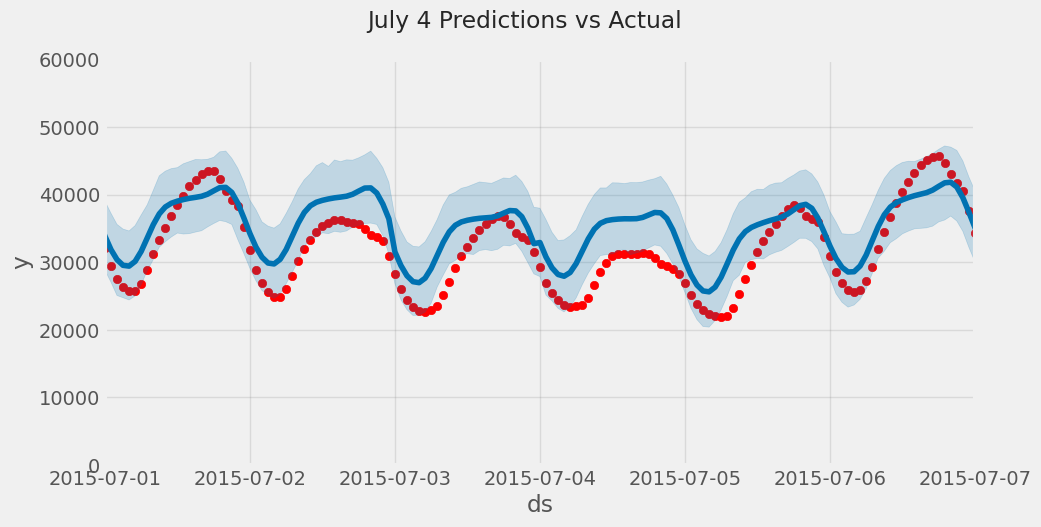

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
lower_date = pd.to_datetime('2015-07-01')
upper_date = pd.to_datetime('2015-07-07')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [26]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

np.float64(6639.651762773761)

In [27]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5201.481641082228

In [28]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

np.float64(16.558679824986207)

In [29]:
#### Evaluate

Simple Prophet Model - Test Set Evaluation
RMSE (Root Mean Squared Error): 6,616.93 MW
MAE (Mean Absolute Error):      5,181.90 MW
MAPE (Mean Absolute % Error):   16.51%
Prophet Model with Holidays - Test Set Evaluation
RMSE (Root Mean Squared Error): 6,639.65 MW
MAE (Mean Absolute Error):      5,201.48 MW
MAPE (Mean Absolute % Error):   16.56%

Model Comparison
Metric                         Simple Model         With Holidays       
------------------------------------------------------------
RMSE (MW)                                6,616.93           6,639.65
MAE (MW)                                 5,181.90           5,201.48
MAPE (%)                                    16.51              16.56
------------------------------------------------------------
Improvement (%)                             -0.34              -0.38              -0.28


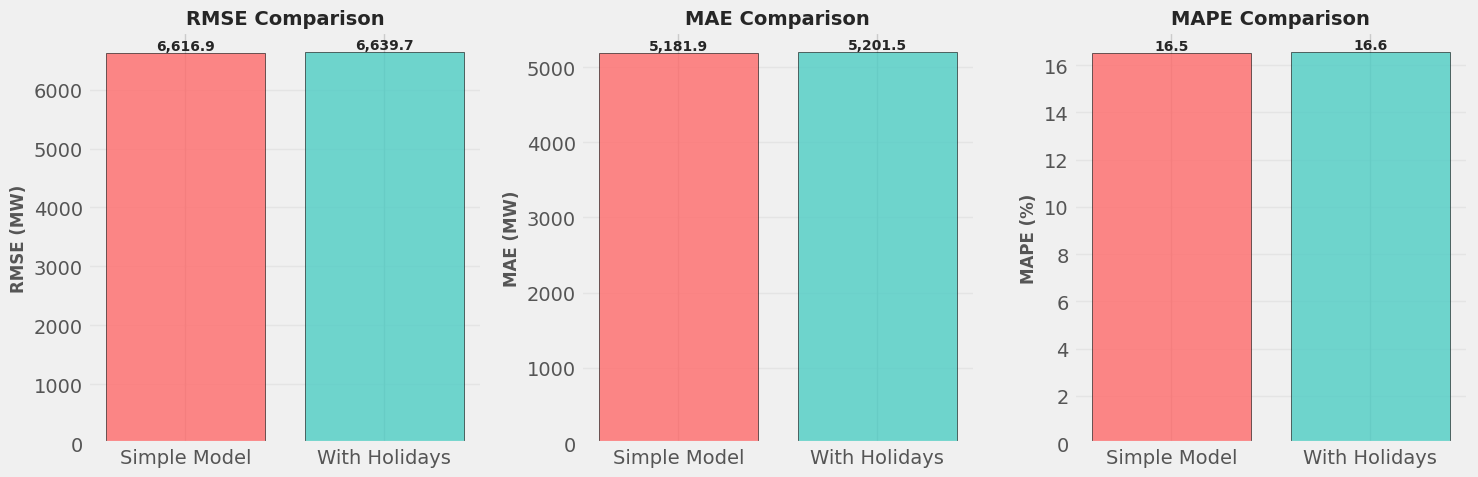

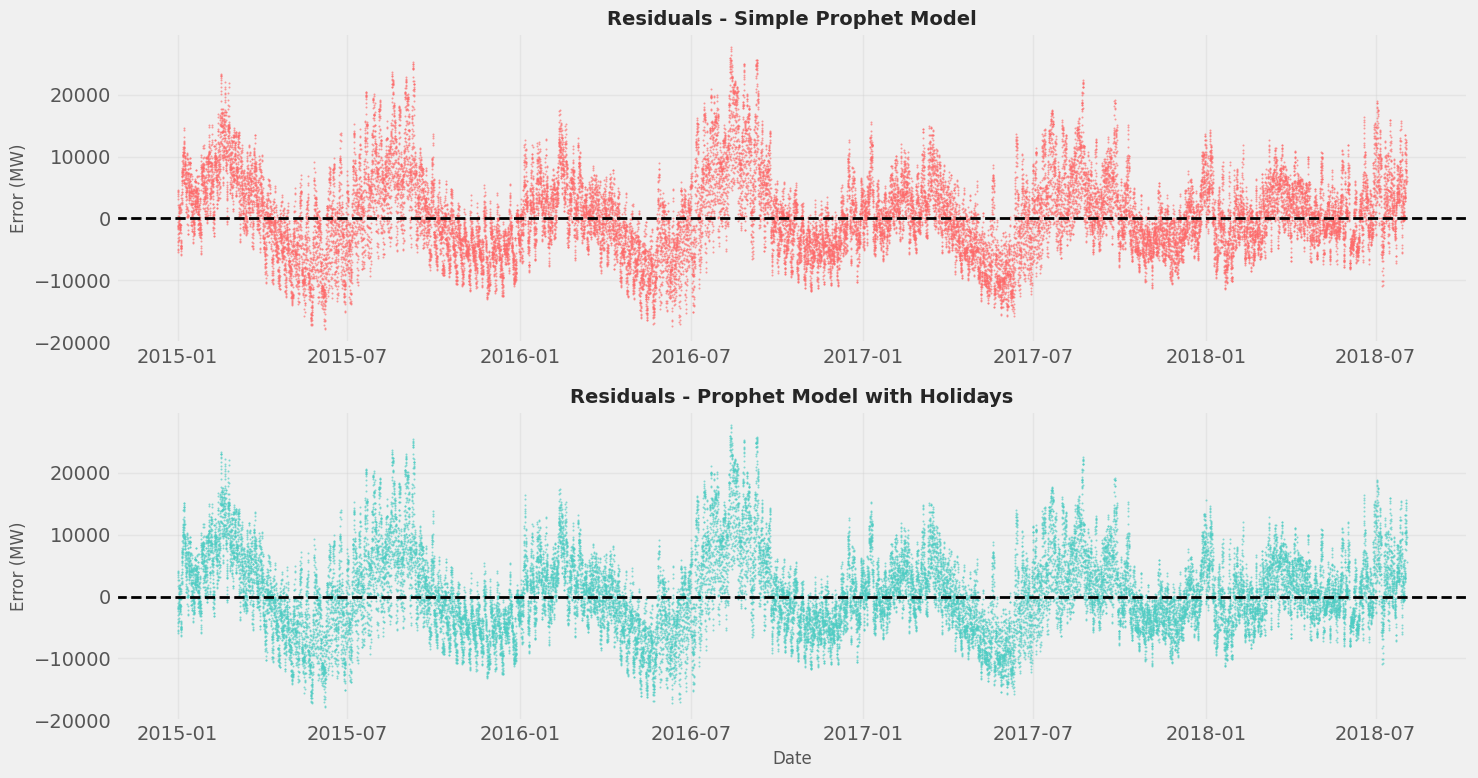


Residual Statistics:
Metric                         Simple Model         With Holidays       
------------------------------------------------------------
Mean Error (MW)                            621.09             680.30
Std Dev of Error (MW)                    6,587.82           6,604.81
Min Error (MW)                         -17,843.35         -17,759.54
Max Error (MW)                          27,662.13          27,681.96


In [30]:

### Evaluate the model with Error Metrics

# Calculate error metrics for the simple model
simple_mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                 y_pred=pjme_test_fcst['yhat'])
simple_mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                             y_pred=pjme_test_fcst['yhat'])
simple_rmse = np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                                         y_pred=pjme_test_fcst['yhat']))

print("=" * 60)
print("Simple Prophet Model - Test Set Evaluation")
print("=" * 60)
print(f"RMSE (Root Mean Squared Error): {simple_rmse:,.2f} MW")
print(f"MAE (Mean Absolute Error):      {simple_mae:,.2f} MW")
print(f"MAPE (Mean Absolute % Error):   {simple_mape:.2f}%")
print("=" * 60)

# Calculate error metrics for the model with holidays
holidays_mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                   y_pred=pjme_test_fcst_with_hols['yhat'])
holidays_mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                               y_pred=pjme_test_fcst_with_hols['yhat'])
holidays_rmse = np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                                           y_pred=pjme_test_fcst_with_hols['yhat']))

print("=" * 60)
print("Prophet Model with Holidays - Test Set Evaluation")
print("=" * 60)
print(f"RMSE (Root Mean Squared Error): {holidays_rmse:,.2f} MW")
print(f"MAE (Mean Absolute Error):      {holidays_mae:,.2f} MW")
print(f"MAPE (Mean Absolute % Error):   {holidays_mape:.2f}%")
print("=" * 60)

# Compare models
print("\n" + "=" * 60)
print("Model Comparison")
print("=" * 60)
print(f"{'Metric':<30} {'Simple Model':<20} {'With Holidays':<20}")
print("-" * 60)
print(f"{'RMSE (MW)':<30} {simple_rmse:>18,.2f} {holidays_rmse:>18,.2f}")
print(f"{'MAE (MW)':<30} {simple_mae:>18,.2f} {holidays_mae:>18,.2f}")
print(f"{'MAPE (%)':<30} {simple_mape:>18.2f} {holidays_mape:>18.2f}")
print("-" * 60)

# Calculate improvement
rmse_improvement = ((simple_rmse - holidays_rmse) / simple_rmse) * 100
mae_improvement = ((simple_mae - holidays_mae) / simple_mae) * 100
mape_improvement = ((simple_mape - holidays_mape) / simple_mape) * 100

print(f"{'Improvement (%)':<30} {rmse_improvement:>18.2f} {mae_improvement:>18.2f} {mape_improvement:>18.2f}")
print("=" * 60)

# Visualize error metrics
import matplotlib.pyplot as plt

metrics = ['RMSE', 'MAE', 'MAPE']
simple_values = [simple_rmse, simple_mae, simple_mape]
holidays_values = [holidays_rmse, holidays_mae, holidays_mape]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric, simple_val, holiday_val) in enumerate(zip(metrics, simple_values, holidays_values)):
    ax = axes[i]
    x = ['Simple Model', 'With Holidays']
    y = [simple_val, holiday_val]

    bars = ax.bar(x, y, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
    ax.set_ylabel(f'{metric} {"(MW)" if metric != "MAPE" else "(%)"}', fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:,.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate residuals (errors) for deeper analysis
pjme_test_with_predictions = pjme_test.copy()
pjme_test_with_predictions['yhat_simple'] = pjme_test_fcst['yhat'].values
pjme_test_with_predictions['yhat_holidays'] = pjme_test_fcst_with_hols['yhat'].values
pjme_test_with_predictions['error_simple'] = pjme_test_with_predictions['PJME_MW'] - pjme_test_with_predictions[
    'yhat_simple']
pjme_test_with_predictions['error_holidays'] = pjme_test_with_predictions['PJME_MW'] - pjme_test_with_predictions[
    'yhat_holidays']

# Plot residuals
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Simple model residuals
axes[0].scatter(pjme_test_with_predictions.index,
                pjme_test_with_predictions['error_simple'],
                alpha=0.5, s=1, color='#FF6B6B')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0].set_title('Residuals - Simple Prophet Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Error (MW)', fontsize=12)
axes[0].grid(alpha=0.3)

# Model with holidays residuals
axes[1].scatter(pjme_test_with_predictions.index,
                pjme_test_with_predictions['error_holidays'],
                alpha=0.5, s=1, color='#4ECDC4')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('Residuals - Prophet Model with Holidays', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (MW)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics of residuals
print("\nResidual Statistics:")
print("=" * 60)
print(f"{'Metric':<30} {'Simple Model':<20} {'With Holidays':<20}")
print("-" * 60)
print(
    f"{'Mean Error (MW)':<30} {pjme_test_with_predictions['error_simple'].mean():>18,.2f} {pjme_test_with_predictions['error_holidays'].mean():>18,.2f}")
print(
    f"{'Std Dev of Error (MW)':<30} {pjme_test_with_predictions['error_simple'].std():>18,.2f} {pjme_test_with_predictions['error_holidays'].std():>18,.2f}")
print(
    f"{'Min Error (MW)':<30} {pjme_test_with_predictions['error_simple'].min():>18,.2f} {pjme_test_with_predictions['error_holidays'].min():>18,.2f}")
print(
    f"{'Max Error (MW)':<30} {pjme_test_with_predictions['error_simple'].max():>18,.2f} {pjme_test_with_predictions['error_holidays'].max():>18,.2f}")
print("=" * 60)

#### Predict

In [31]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [32]:
forecast[['ds','yhat']].head()


,ds,yhat
0,2015-01-01 01:00:00,25566.734542
1,2015-01-01 02:00:00,24064.813557
2,2015-01-01 03:00:00,23195.290712
3,2015-01-01 04:00:00,23055.674425
4,2015-01-01 05:00:00,23731.654437


#### LightBGM

In [33]:

#### LightGBM

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare features for LightGBM using the same train/test split
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Convert categorical features
cat_features = ['season']
for cat_col in cat_features:
    X_train[cat_col] = X_train[cat_col].astype('category')
    X_test[cat_col] = X_test[cat_col].astype('category')


In [34]:

%%time
# Train LightGBM model
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)


CPU times: user 68 μs, sys: 4 μs, total: 72 μs
Wall time: 76.3 μs


In [35]:
%%time
lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)


CPU times: user 3.71 s, sys: 3.06 s, total: 6.77 s
Wall time: 2.23 s


,boosting_type,'gbdt'
,num_leaves,100
,max_depth,10
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [36]:

# Make predictions with LightGBM
lgb_predictions = lgb_model.predict(X_test)



In [42]:
X_test[:2]

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
Datetime,,,,,,,,,
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,Winter
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,Winter


In [37]:

# Create a dataframe with predictions
lgb_results = pjme_test.copy()
lgb_results['lgb_pred'] = lgb_predictions
# short result by date ascending
lgb_results = lgb_results.sort_index()


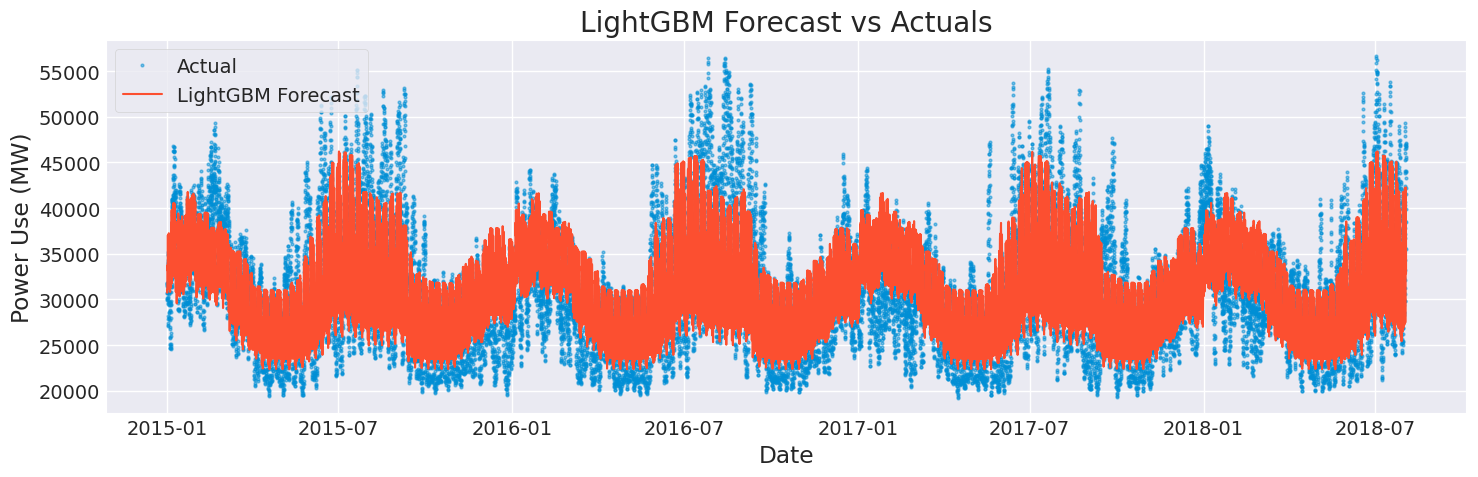

In [38]:

# Plot LightGBM predictions vs actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(lgb_results.index, lgb_results['PJME_MW'], 'o', ms=2, label='Actual', alpha=0.5)
ax.plot(lgb_results.index, lgb_results['lgb_pred'], '-', label='LightGBM Forecast', linewidth=1.5)
ax.set_title('LightGBM Forecast vs Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Power Use (MW)')
ax.legend()
plt.tight_layout()
plt.show()


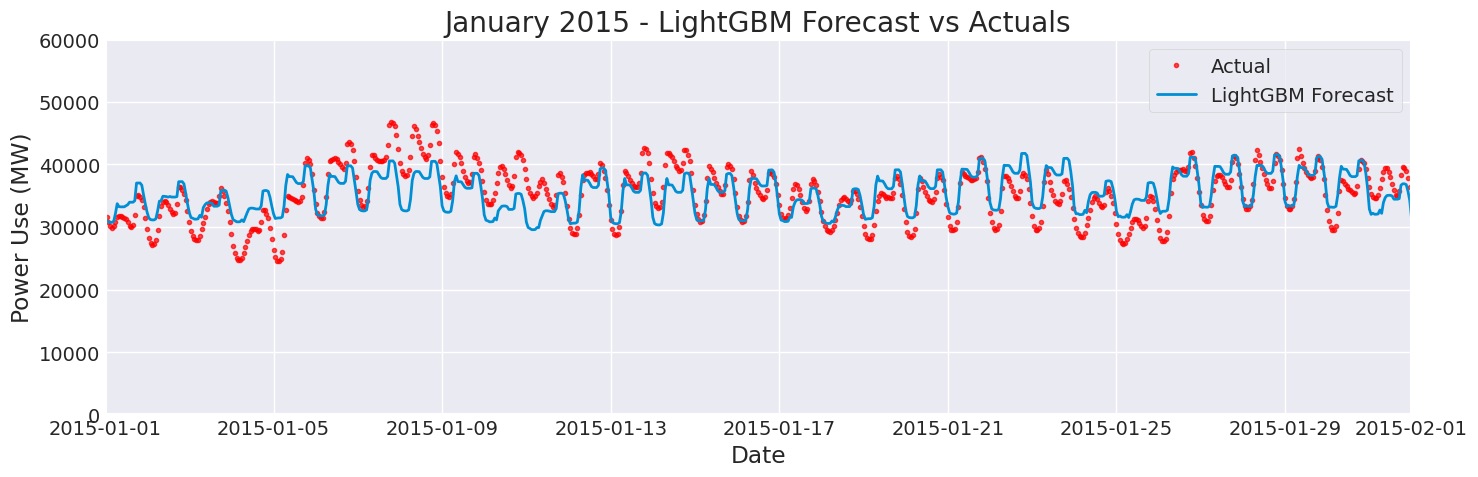

In [39]:

# Zoom in on January 2015
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(lgb_results.index, lgb_results['PJME_MW'], 'o', ms=3, label='Actual', alpha=0.7, color='red')
ax.plot(lgb_results.index, lgb_results['lgb_pred'], '-', label='LightGBM Forecast', linewidth=2)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), upper=pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set_title('January 2015 - LightGBM Forecast vs Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Power Use (MW)')
ax.legend()
plt.tight_layout()
plt.show()


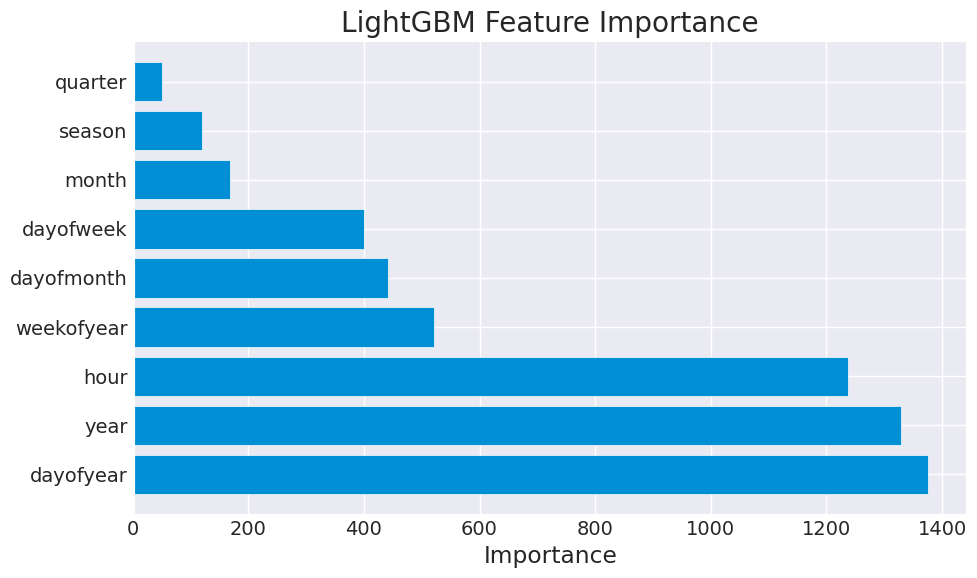

In [40]:

# Feature importance
fig, ax = plt.subplots(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

ax.barh(importance_df['feature'], importance_df['importance'])
ax.set_xlabel('Importance')
ax.set_title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()



MODEL COMPARISON: Prophet (with Holidays) vs. LightGBM

Metric                              Prophet              LightGBM             Winner         
--------------------------------------------------------------------------------
MAE (Mean Absolute Error)                     5,201.48           2,982.08      LightGBM
MAPE (Mean Absolute % Error)                    16.56%              9.49%      LightGBM
RMSE (Root Mean Squared Error)                6,639.65           3,848.68      LightGBM

Peak Demand Analysis               
  Actual Peak Demand (MW)                    56,609.00
  Prophet Prediction at Peak                 38,021.94          46,148.52
  Peak Absolute Error (MW)                   18,587.06          10,460.48      LightGBM
  Peak Percentage Error (%)                     32.83%             18.48%      LightGBM

Pinball Loss Scores                
  Quantile 0.1                                2,328.62           1,692.57      LightGBM
  Quantile 0.5                        

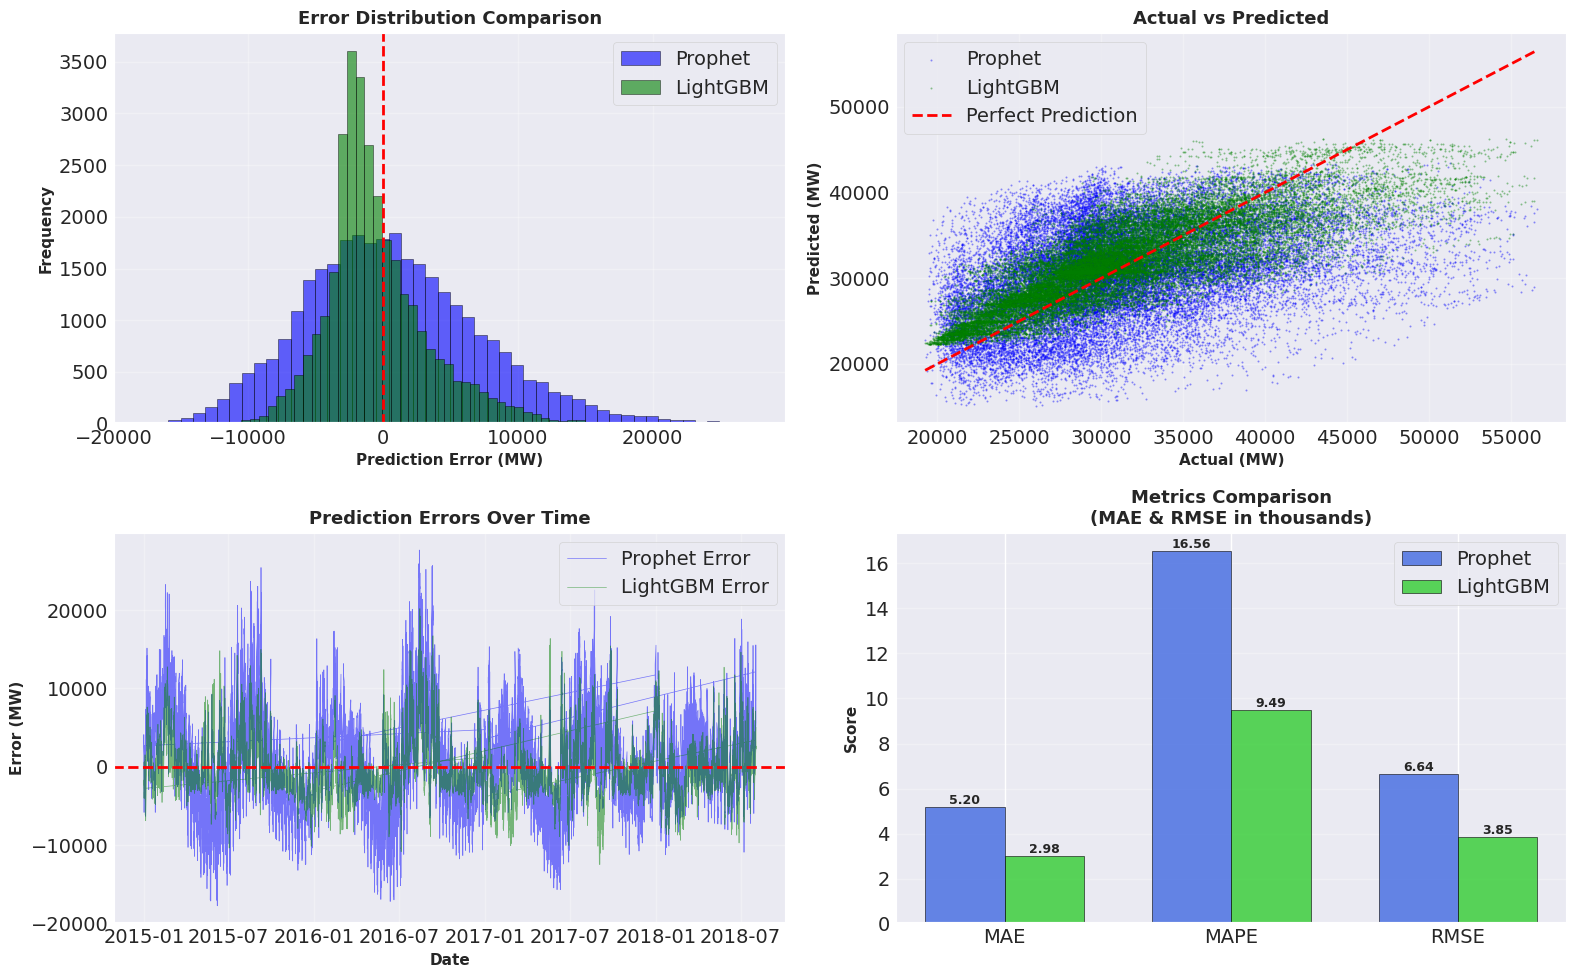

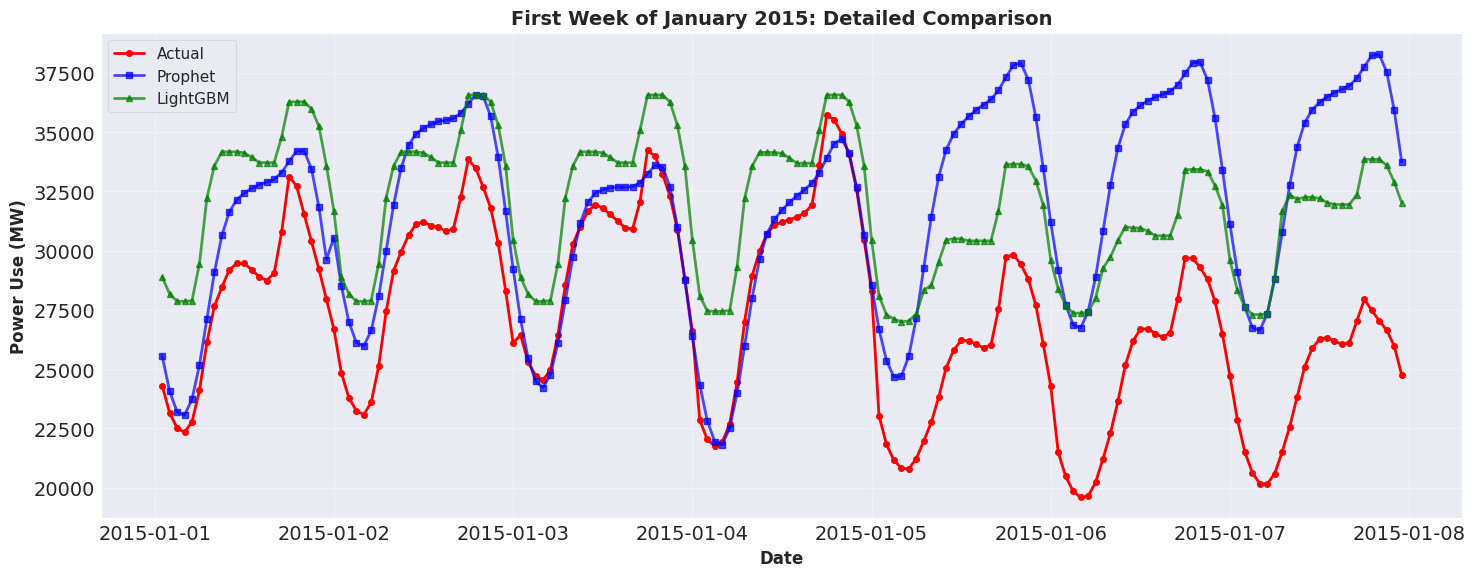


COMPREHENSIVE MODEL COMPARISON SUMMARY
                   Metric      Prophet     LightGBM  Improvement (%)   Winner
                 MAE (MW)  5201.481641  2982.084005            42.67 LightGBM
                 MAPE (%)    16.558680     9.490460            42.69 LightGBM
                RMSE (MW)  6639.651763  3848.683771            42.03 LightGBM
 Peak Absolute Error (MW) 18587.061446 10460.482652            43.72 LightGBM
Peak Percentage Error (%)    32.834110    18.478480            43.72 LightGBM
     Pinball Loss (q=0.1)  2328.619212  1692.569067            27.31 LightGBM
     Pinball Loss (q=0.5)  2600.740821  1491.042003            42.67 LightGBM
     Pinball Loss (q=0.9)  2872.862429  1289.514938            55.11 LightGBM

Note: Positive improvement means LightGBM performs better.
Overall Winner: LightGBM (won 8/8 metrics)


In [41]:

### Compare Prophet vs. LightGBM

def pinball_loss(y_true, y_pred, quantile=0.5):
    """
    Calculate pinball loss for quantile regression.
    quantile=0.5 is equivalent to MAE
    """
    residual = y_true - y_pred
    return np.mean(np.maximum(quantile * residual, (quantile - 1) * residual))


def peak_forecast_error(y_true, y_pred):
    """
    Calculate error on peak demand forecasting.
    Returns the absolute error on the maximum value.
    """
    actual_peak = np.max(y_true)
    actual_peak_idx = np.argmax(y_true)
    predicted_peak_value = y_pred[actual_peak_idx]

    return {
        'actual_peak': actual_peak,
        'predicted_at_peak': predicted_peak_value,
        'peak_absolute_error': abs(actual_peak - predicted_peak_value),
        'peak_percentage_error': abs(actual_peak - predicted_peak_value) / actual_peak * 100
    }


# Prepare predictions for comparison
prophet_pred = pjme_test_fcst_with_hols['yhat'].values
# sort prophet predictions by date ascending
prophet_pred = prophet_pred
lgb_pred = lgb_predictions
actual = pjme_test['PJME_MW'].values

# Calculate all metrics for both models
print("=" * 80)
print("MODEL COMPARISON: Prophet (with Holidays) vs. LightGBM")
print("=" * 80)

# MAE
prophet_mae = mean_absolute_error(actual, prophet_pred)
lgb_mae = mean_absolute_error(actual, lgb_pred)

print(f"\n{'Metric':<35} {'Prophet':<20} {'LightGBM':<20} {'Winner':<15}")
print("-" * 80)
print(
    f"{'MAE (Mean Absolute Error)':<35} {prophet_mae:>18,.2f} {lgb_mae:>18,.2f} {' ' * 5}{'Prophet' if prophet_mae < lgb_mae else 'LightGBM'}")

# MAPE
prophet_mape = mean_absolute_percentage_error(actual, prophet_pred)
lgb_mape = mean_absolute_percentage_error(actual, lgb_pred)
print(
    f"{'MAPE (Mean Absolute % Error)':<35} {prophet_mape:>17,.2f}% {lgb_mape:>17,.2f}% {' ' * 5}{'Prophet' if prophet_mape < lgb_mape else 'LightGBM'}")

# RMSE
prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_pred))
lgb_rmse = np.sqrt(mean_squared_error(actual, lgb_pred))
print(
    f"{'RMSE (Root Mean Squared Error)':<35} {prophet_rmse:>18,.2f} {lgb_rmse:>18,.2f} {' ' * 5}{'Prophet' if prophet_rmse < lgb_rmse else 'LightGBM'}")

# Peak Forecast Error
prophet_peak = peak_forecast_error(actual, prophet_pred)
lgb_peak = peak_forecast_error(actual, lgb_pred)
print(f"\n{'Peak Demand Analysis':<35}")
print(f"{'  Actual Peak Demand (MW)':<35} {prophet_peak['actual_peak']:>18,.2f}")
print(
    f"{'  Prophet Prediction at Peak':<35} {prophet_peak['predicted_at_peak']:>18,.2f} {lgb_peak['predicted_at_peak']:>18,.2f}")
print(
    f"{'  Peak Absolute Error (MW)':<35} {prophet_peak['peak_absolute_error']:>18,.2f} {lgb_peak['peak_absolute_error']:>18,.2f} {' ' * 5}{'Prophet' if prophet_peak['peak_absolute_error'] < lgb_peak['peak_absolute_error'] else 'LightGBM'}")
print(
    f"{'  Peak Percentage Error (%)':<35} {prophet_peak['peak_percentage_error']:>17,.2f}% {lgb_peak['peak_percentage_error']:>17,.2f}% {' ' * 5}{'Prophet' if prophet_peak['peak_percentage_error'] < lgb_peak['peak_percentage_error'] else 'LightGBM'}")

# Pinball Loss (multiple quantiles)
print(f"\n{'Pinball Loss Scores':<35}")
quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    prophet_pinball = pinball_loss(actual, prophet_pred, quantile=q)
    lgb_pinball = pinball_loss(actual, lgb_pred, quantile=q)
    print(
        f"{'  Quantile ' + str(q):<35} {prophet_pinball:>18,.2f} {lgb_pinball:>18,.2f} {' ' * 5}{'Prophet' if prophet_pinball < lgb_pinball else 'LightGBM'}")

print("=" * 80)

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Error distribution
axes[0, 0].hist(actual - prophet_pred, bins=50, alpha=0.6, label='Prophet', color='blue', edgecolor='black')
axes[0, 0].hist(actual - lgb_pred, bins=50, alpha=0.6, label='LightGBM', color='green', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (MW)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Error Distribution Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter plot comparison
axes[0, 1].scatter(actual, prophet_pred, alpha=0.3, s=1, label='Prophet', color='blue')
axes[0, 1].scatter(actual, lgb_pred, alpha=0.3, s=1, label='LightGBM', color='green')
axes[0, 1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=2,
                label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual (MW)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Predicted (MW)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Actual vs Predicted', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Time series of errors
prophet_errors = actual - prophet_pred
lgb_errors = actual - lgb_pred
axes[1, 0].plot(pjme_test.index, prophet_errors, alpha=0.5, linewidth=0.5, label='Prophet Error', color='blue')
axes[1, 0].plot(pjme_test.index, lgb_errors, alpha=0.5, linewidth=0.5, label='LightGBM Error', color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Error (MW)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Prediction Errors Over Time', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Metrics comparison bar chart
metrics_names = ['MAE', 'MAPE', 'RMSE']
prophet_metrics = [prophet_mae / 1000, prophet_mape, prophet_rmse / 1000]  # Scale for visualization
lgb_metrics = [lgb_mae / 1000, lgb_mape, lgb_rmse / 1000]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[1, 1].bar(x - width / 2, prophet_metrics, width, label='Prophet', color='#4169E1', alpha=0.8,
                       edgecolor='black')
bars2 = axes[1, 1].bar(x + width / 2, lgb_metrics, width, label='LightGBM', color='#32CD32', alpha=0.8,
                       edgecolor='black')

axes[1, 1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Metrics Comparison\n(MAE & RMSE in thousands)', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2., height,
                        f'{height:.2f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison for a specific week
week_start = pd.to_datetime('2015-01-01')
week_end = pd.to_datetime('2015-01-08')
pjme_test_tmp = pjme_test.copy().sort_index()
week_mask = (pjme_test_tmp.index >= week_start) & (pjme_test_tmp.index < week_end)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(pjme_test_tmp.index[week_mask], actual[week_mask], 'o-', label='Actual', linewidth=2, markersize=4, color='red')
ax.plot(pjme_test_tmp.index[week_mask], prophet_pred[week_mask], 's-', label='Prophet', linewidth=2, markersize=4,
        alpha=0.7, color='blue')
ax.plot(pjme_test_tmp.index[week_mask], lgb_pred[week_mask], '^-', label='LightGBM', linewidth=2, markersize=4, alpha=0.7,
        color='green')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Power Use (MW)', fontsize=12, fontweight='bold')
ax.set_title('First Week of January 2015: Detailed Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics table
comparison_df = pd.DataFrame({
    'Metric': [
        'MAE (MW)',
        'MAPE (%)',
        'RMSE (MW)',
        'Peak Absolute Error (MW)',
        'Peak Percentage Error (%)',
        'Pinball Loss (q=0.1)',
        'Pinball Loss (q=0.5)',
        'Pinball Loss (q=0.9)'
    ],
    'Prophet': [
        prophet_mae,
        prophet_mape,
        prophet_rmse,
        prophet_peak['peak_absolute_error'],
        prophet_peak['peak_percentage_error'],
        pinball_loss(actual, prophet_pred, 0.1),
        pinball_loss(actual, prophet_pred, 0.5),
        pinball_loss(actual, prophet_pred, 0.9)
    ],
    'LightGBM': [
        lgb_mae,
        lgb_mape,
        lgb_rmse,
        lgb_peak['peak_absolute_error'],
        lgb_peak['peak_percentage_error'],
        pinball_loss(actual, lgb_pred, 0.1),
        pinball_loss(actual, lgb_pred, 0.5),
        pinball_loss(actual, lgb_pred, 0.9)
    ]
})

comparison_df['Improvement (%)'] = (
            (comparison_df['Prophet'] - comparison_df['LightGBM']) / comparison_df['Prophet'] * 100).round(2)
comparison_df['Winner'] = comparison_df.apply(lambda row: 'LightGBM' if row['LightGBM'] < row['Prophet'] else 'Prophet',
                                              axis=1)

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)
print(f"\nNote: Positive improvement means LightGBM performs better.")
print(f"Overall Winner: {comparison_df['Winner'].value_counts().idxmax()} "
      f"(won {comparison_df['Winner'].value_counts().max()}/{len(comparison_df)} metrics)")
print("=" * 100)

#### Save

In [189]:
# Export model lightgbm and prophet models for future use.

# Export LightGBM and Prophet models for future use
import joblib
import json
from pathlib import Path
import lightgbm as lgb

# Create models directory if it doesn't exist
models_dir = Path(os.path.join(os.getcwd(),'../../models'))
models_dir.mkdir(exist_ok=True)

# Save LightGBM model
lgb_model_path = models_dir / 'lightgbm_power_forecast.pkl'
joblib.dump(lgb_model, lgb_model_path)
print(f"✓ LightGBM model saved to: {lgb_model_path}")

# Save Prophet model with holidays
prophet_model_path = models_dir / 'prophet_power_forecast_with_holidays.pkl'
joblib.dump(model_with_holidays, prophet_model_path)
print(f"✓ Prophet model (with holidays) saved to: {prophet_model_path}")

# Save a simple Prophet model (optional)
prophet_simple_path = models_dir / 'prophet_power_forecast_simple.pkl'
joblib.dump(model, prophet_simple_path)
print(f"✓ Prophet model (simple) saved to: {prophet_simple_path}")

# Save model metadata and performance metrics
model_metadata = {
    'lightgbm': {
        'model_type': 'LightGBM Regressor',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_period': f"{pjme_train.index.min()} to {pjme_train.index.max()}",
        'test_period': f"{pjme_test.index.min()} to {pjme_test.index.max()}",
        'metrics': {
            'MAE': float(lgb_mae),
            'MAPE': float(lgb_mape),
            'RMSE': float(lgb_rmse),
            'peak_absolute_error': float(lgb_peak['peak_absolute_error']),
            'peak_percentage_error': float(lgb_peak['peak_percentage_error'])
        },
        'hyperparameters': {
            'n_estimators': lgb_model.n_estimators,
            'learning_rate': lgb_model.learning_rate,
            'max_depth': lgb_model.max_depth,
            'num_leaves': lgb_model.num_leaves,
            'min_child_samples': lgb_model.min_child_samples,
            'subsample': lgb_model.subsample,
            'colsample_bytree': lgb_model.colsample_bytree
        },
        'features': list(X_train.columns),
        'categorical_features': cat_features
    },
    'prophet_with_holidays': {
        'model_type': 'Prophet with US Federal Holidays',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_period': f"{pjme_train.index.min()} to {pjme_train.index.max()}",
        'test_period': f"{pjme_test.index.min()} to {pjme_test.index.max()}",
        'metrics': {
            'MAE': float(holidays_mae),
            'MAPE': float(holidays_mape),
            'RMSE': float(holidays_rmse),
            'peak_absolute_error': float(prophet_peak['peak_absolute_error']),
            'peak_percentage_error': float(prophet_peak['peak_percentage_error'])
        },
        'holidays_included': True,
        'holiday_count': len(holiday_df)
    },
    'prophet_simple': {
        'model_type': 'Prophet (Simple)',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_period': f"{pjme_train.index.min()} to {pjme_train.index.max()}",
        'test_period': f"{pjme_test.index.min()} to {pjme_test.index.max()}",
        'metrics': {
            'MAE': float(simple_mae),
            'MAPE': float(simple_mape),
            'RMSE': float(simple_rmse)
        },
        'holidays_included': False
    },
    'comparison': {
        'best_model': comparison_df['Winner'].value_counts().idxmax(),
        'winner_count': f"{comparison_df['Winner'].value_counts().max()}/{len(comparison_df)} metrics"
    }
}

# Save metadata as JSON
metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=4)
print(f"✓ Model metadata saved to: {metadata_path}")

# Save feature importance for LightGBM
feature_importance_path = models_dir / 'lightgbm_feature_importance.csv'
importance_df.to_csv(feature_importance_path, index=False)
print(f"✓ Feature importance saved to: {feature_importance_path}")

# Save comparison results
comparison_path = models_dir / 'model_comparison_results.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Model comparison results saved to: {comparison_path}")

print("\n" + "=" * 100)
print("MODEL EXPORT SUMMARY")
print("=" * 100)
print(f"All models and metadata successfully saved to: {models_dir.absolute()}")
print(f"\nFiles created:")
print(f"  1. {lgb_model_path.name} - LightGBM model")
print(f"  2. {prophet_model_path.name} - Prophet model with holidays")
print(f"  3. {prophet_simple_path.name} - Simple Prophet model")
print(f"  4. {metadata_path.name} - Model metadata and metrics")
print(f"  5. {feature_importance_path.name} - LightGBM feature importance")
print(f"  6. {comparison_path.name} - Model comparison results")
print("=" * 100)


print("\n" + "=" * 100)
print("TO LOAD MODELS LATER, USE:")
print("=" * 100)
print("""
# Load LightGBM model
lgb_model_loaded = joblib.load('models/lightgbm_power_forecast.pkl')

# Load Prophet model with holidays
prophet_model_loaded = joblib.load('models/prophet_power_forecast_with_holidays.pkl')

# Load metadata
with open('models/model_metadata.json', 'r') as f:
    metadata = json.load(f)
""")
print("=" * 100)

✓ LightGBM model saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/lightgbm_power_forecast.pkl
✓ Prophet model (with holidays) saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/prophet_power_forecast_with_holidays.pkl
✓ Prophet model (simple) saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/prophet_power_forecast_simple.pkl
✓ Model metadata saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/model_metadata.json
✓ Feature importance saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/lightgbm_feature_importance.csv
✓ Model comparison results saved to: /home/alitonia/.config/JetBrains/DataSpell2025.2/projects/workspace/code/predict/../../models/model_comparison_results.csv

MODEL EXPORT SUMMARY
All models and metadata success